# [LVV-T2214] - MTMount_Elevation_Changes_with_MTAOS_Aberrations

This notebook was originally written by Bo Xin in the [lsst-ts/ts_notebooks] repository.  
It is a modified version with updated commands and simplified steps.

**Make sure you run this notebook on TTS before running at the summit.**

[lsst-ts/ts_notebooks]: https://github.com/lsst-ts/ts_notebooks/blob/develop/bxin/aos2comp/aos2comp.ipynb
[LVV-T2214]: https://jira.lsstcorp.org/secure/Tests.jspa#/testCase/LVV-T2214

## Requirements

This notebooks require some extra repositories to be installed locally so it can grab some constants and some look-up tables.  
Here is a list of which repos are these:

* [lsst-ts/ts_cRIOpy]

[lsst-ts/ts_cRIOpy]: https://github.com/lsst-ts/ts_cRIOpy 
[lsst-ts/ts_m1m3support]: https://github.com/lsst-ts/ts_m1m3support

To install them, open a terminal and run the following commands:

```
git clone https://github.com/lsst-ts/ts_cRIOpy $HOME/notebooks/lsst-ts/ts_cRIOpy
git clone https://github.com/lsst-ts/ts_m1m3support.git $HOME/notebooks/lsst-ts/ts_m1m3support
git clone https://github.com/lsst-ts/ts_config_mttcs $HOME/notebooks/lsst-ts/ts_config_mttcs
git clone https://github.com/lsst-sitcom/M2_FEA $HOME/notebooks/lsst-sitcom/M2_FEA
```

And add these lines to your `$HOME/notebooks/.user_setup` file: 

```
setup -j notebooks_vandv -r ~/notebooks/lsst-sitcom/notebooks_vandv
setup -j ts_cRIOpy -r $HOME/notebooks/lsst-ts/ts_cRIOpy
```

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from lsst.sitcom import vandv

exec_info = vandv.ExecutionInfo()
print(exec_info)


Executed by isotuela on 2022-06-14T16:04:36.192.
  Running in pillan01 at tucson



---
## Setup Notebook for Test

- Import all libraries
- Get the remotes ready

In [3]:
test_execution = "Test Tue14"

In [4]:
import asyncio
import os
import yaml

import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from astropy import time 
from astropy.coordinates import AltAz, ICRS, EarthLocation, Angle, FK5
from datetime import datetime, timedelta

from lsst_efd_client import EfdClient
from lsst.ts import utils, salobj
from lsst.ts.cRIOpy import M1M3FATable
from lsst.ts.observatory.control.maintel.mtcs import MTCS, MTCSUsages
from lsst.ts.observatory.control import RotType

import lsst.sitcom.vandv as vandv

In [16]:
print(os.environ.get("LSST_DDS_DOMAIN_ID"))

None


In [18]:
print(os.environ["OSPL_URI"])
print(os.environ["LSST_DDS_PARTITION_PREFIX"])
print(os.environ.get("LSST_DDS_DOMAIN_ID"))

file:///opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-3.0.0/lib/python3.8/config/ospl-shmem.xml
tucson
None


In [6]:
logging.basicConfig(format="%(name)s:%(message)s", level=logging.DEBUG)

In [7]:
log = logging.getLogger("setup")
log.level = logging.DEBUG

In [8]:
domain = salobj.Domain()

In [9]:
mtcs = MTCS(domain=domain, log=log)
mtcs.set_rem_loglevel(40)

In [10]:
await mtcs.start_task

[None, None, None, None, None, None, None, None, None, None]

In [24]:
client = EfdClient("tucson_teststand_efd")


## Helper Functions

In [60]:
async def get_data_from_efd(location, start, end):
    """
    Retrieves data relevant for analysis.
    
    Parameters
    ----------
    location : str
        In which Test Stand are you running this test?
    start : str or datetime
        Start of the time-window.
    end : str or datetime 
        End of the time-window.
    """
    if location == "summit":
        client = EfdClient("summit_efd")
    elif location == "tucson":
        client = EfdClient("tucson_teststand_efd")
    else:
        raise ValueError(
            "Location does not match any valid options {summit|tucson}"
        )
    
    _df_mount_el = await client.select_time_series(
        "lsst.sal.MTMount.elevation", 
        fields="actualPosition", 
        start=start, 
        end=end,
    )
    
    _df_m1m3_101 = await client.select_time_series(
        "lsst.sal.MTM1M3.forceActuatorData",
        fields="zForce101",
        start=start, 
        end=end,
    )
        
    # M2 B1?
    _df_m2 = await client.select_time_series(
        "lsst.sal.MTM2.axialForce",
        fields=[
            "applied0",
            "lutGravity0",
        ],
        start=start, 
        end=end,
    )
    
    # CamHex Y position
    _df_camhex = await client.select_time_series(
        "lsst.sal.MTHexapod.application",
        fields=[
            "position1"
        ],
        index=1,
        start=start, 
        end=end,
    )
    
    # M2Hex Y position
    _df_m2hex = await client.select_time_series(
        "lsst.sal.MTHexapod.application",
        fields=[
            "position1"
        ],
        index=2,
        start=start, 
        end=end,
    )

    # Rename columns
    _df_mount_el.rename(columns={"actualPosition": "mount_el"}, inplace=True)
    _df_m1m3_101.rename(columns={"zForce101": "m1m3_z101"}, inplace=True)
    _df_m2.rename(columns={"applied0": "m2b1_applied", "lutGravity0": "m2b1_gravLut"}, inplace=True)
    _df_camhex.rename(columns={"position1": "camhex_y"}, inplace=True)
    _df_m2hex.rename(columns={"position1": "m2hex_y"}, inplace=True)

    
    # Join dataframes
    _df = _df_mount_el
    
    _df = pd.merge(
        _df, 
        _df_m1m3_101, 
        left_index=True, 
        right_index=True, 
        how="outer"
    )
         
    _df = pd.merge(
        _df, 
        _df_m2, 
        left_index=True, 
        right_index=True, 
        how="outer"
    )
    
    _df = pd.merge(
        _df, 
        _df_camhex, 
        left_index=True, 
        right_index=True, 
        how="outer"
    )

    _df = pd.merge(
        _df, 
        _df_m2hex, 
        left_index=True, 
        right_index=True, 
        how="outer"
    )
    
    return _df

## Start all the components, and put them in an enabled state.

Depending on which test cycle this is being executed in, each component is either a hardware component or a simulator:

- [ ] M1M3
- [ ] M2 
- [ ] M2 Hexapod
- [ ] Camera Hexapod
- [ ] MTMount
- [ ] MTRotator
- [ ] MTPtg

The best/simplest way of doing this is running the notebook that executes the [LVV-T2344] test case.  
This notebook puts all the components in a ENABLED state.

[LVV-T2344]: https://github.com/lsst-sitcom/notebooks_vandv/blob/develop/notebooks/proj_sys_eng/sitcom_integration/l3_system_integ/LVV-T2344-Startup_mt_on_level3.ipynb

In [12]:
# Verify that all the components have heartbeats
await mtcs.assert_liveliness()

In [13]:
# Verify that all the components are enabled
await mtcs.assert_all_enabled()

---
## Check elevation motion is smooth and no abrupt changes occur (Otherwise it faults M1M3) 

Do the following slew sequence, watch chronograph to make sure there is no abrupt change in elevation angle (otherwise it faults M1M3).

Do 4 slews in sequence. For each slew, track for 39s, simulating a visit.
Note: the 4 slews need to correspond to elevation angle between 86.5 deg and 82 deg. And, additional margin is needed due to tracking.

Move to zenith at the end (so that we can start m1m3 with LUT in mount telemetry mode)

In [21]:
# Create between 86.5 and 82 deg elevation. 
target_1 = mtcs.radec_from_azel(az=230.5, el=85.4)
target_2 = mtcs.radec_from_azel(az=231, el=84.5)
target_3 = mtcs.radec_from_azel(az=230.5, el=83.4)
target_4 = mtcs.radec_from_azel(az=231, el=82.5)

print(f"Target 1: {target_1}\n"
      f"Target 2: {target_2}\n"
      f"Target 3: {target_3}\n"
      f"Target 4: {target_4}\n")

Target 1: <ICRS Coordinate: (ra, dec) in deg
    (70.2736724, -33.14582989)>
Target 2: <ICRS Coordinate: (ra, dec) in deg
    (69.38017378, -33.65130235)>
Target 3: <ICRS Coordinate: (ra, dec) in deg
    (68.34975608, -34.34631135)>
Target 4: <ICRS Coordinate: (ra, dec) in deg
    (67.41987385, -34.8234876)>



In [22]:
# Set this to True when you actually want to run this test
if True:
    t_start = Time(Time.now(), format='fits', scale='utc') 
    #time.Time(utils.current_tai(), format="unix", scale="tai")
    #t_start.format = "isot"
    print(f"Gathering data - Elevation motion test - Start time: {t_start}")

    await asyncio.sleep(2.)

    # First target
    print('Slewing to first source')
    await mtcs.slew_icrs(ra=target_1.ra, dec=target_1.dec, rot_type=RotType.PhysicalSky)
    await asyncio.sleep(39.)
    
    #await mtcs.stop_tracking()

    
    # Second target
    print('Slewing to second source')
    await mtcs.slew_icrs(ra=target_2.ra, dec=target_2.dec, rot_type=RotType.PhysicalSky)
    await asyncio.sleep(39.)
    
    #await mtcs.stop_tracking()

    
    # Third target
    print('Slewing to third source')
    await mtcs.slew_icrs(ra=target_3.ra, dec=target_3.dec, rot_type=RotType.PhysicalSky)
    await asyncio.sleep(39.)
    
    #await mtcs.stop_tracking()

    
    # Fourth target 
    print('Slewing to fourth source') 
    await mtcs.slew_icrs(ra=target_4.ra, dec=target_4.dec, rot_type=RotType.PhysicalSky)
    await asyncio.sleep(39.)
    
    # Stop tracking
    await mtcs.stop_tracking()
    
    t_end = Time(Time.now(), format='fits', scale='utc')
    # time.Time(utils.current_tai(), format="unix", scale="tai")
    # t_end.format = "isot"
    print(f"Gathering data - Elevation motion test - End time: {t_end}")
    

Gathering data - Elevation motion test - Start time: 2022-06-14T16:10:42.744
Slewing to first source


Slewing to second source


Slewing to third source


Slewing to fourth source


Gathering data - Elevation motion test - End time: 2022-06-14T16:15:13.914


In [61]:
# Plot mount elevation as a function of time
# Query telemetry
dfm_elevation = await client.select_time_series('lsst.sal.MTMount.elevation', 'actualPosition', t_start.utc, t_end.utc)

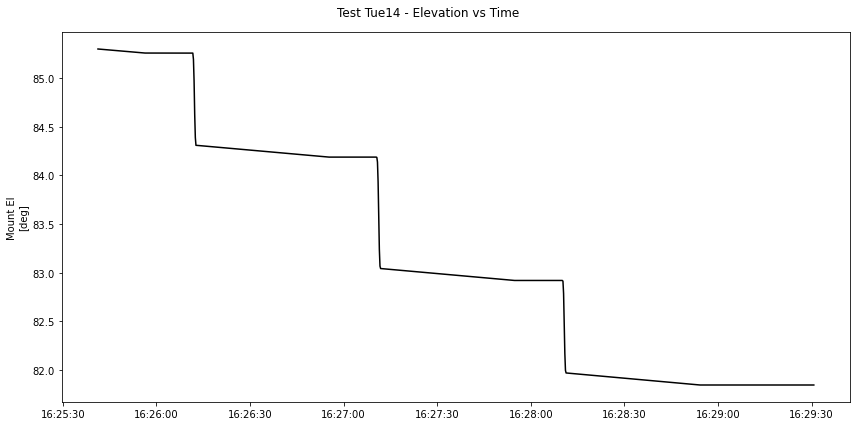

In [62]:
# Plot 
fig, axs = plt.subplots(figsize=(12, 6), sharex=True)

axs.plot(dfm_elevation["actualPosition"].dropna(), "k", label="Mount Elevation")
axs.set_ylabel("Mount El\n[deg]")

fig.suptitle(f"{test_execution} - Elevation vs Time")
fig.tight_layout(h_pad=0.3)
fig.patch.set_facecolor('white')   

fig.savefig(f"plots/{test_execution}_mount_el_vs_time.png")
plt.show()

In [27]:
# Move to zenith
await mtcs.point_azel(az=0, el=90)

---
## Get M1M3 Ready

- Raise the mirror,
- Turn on Balance Forces,
- Clear forces

Need to have M1M3 LUT use mount telemetry.

In [28]:
# If M1M3 is not raised yet, use this command to raise it.
await mtcs.raise_m1m3()

In [29]:
# Enables M1M3 Force Balance system using the hardpoints
await mtcs.enable_m1m3_balance_system()

In [30]:
# Resets the Aberration Forces and the Active Optics Forces
await mtcs.reset_m1m3_forces()

In [ ]:
# M1M3 LUT use mount telemetry
# todo: how to do that? 

## Get M2 Ready
- Turn on Force Balance system
- Clear forces

In [31]:
# Enabled M2 Force Balance system 
await mtcs.enable_m2_balance_system()

In [32]:
# Resets the Active Optics Forces
await mtcs.reset_m2_forces()

In [ ]:
# Need to have M2 LUT use mount telemetry
# todo: how to do that?

## Get CamHex Ready
- Check config 
- Make sure LUT is on, and has valid inputs
- Make sure hex is at LUT position

In [33]:
# Check the configuration
await vandv.hexapod.get_hexapod_configuration(mtcs.rem.mthexapod_1)

None


TimeoutError: 

In [34]:
# Enable compensation mode for CamHex
await mtcs.enable_compensation_mode("mthexapod_1")

In [35]:
# Reset the Camera Hexapod position
await mtcs.reset_camera_hexapod_position()

In [36]:
# After resetting the Camera Hexapod position, we want to make sure that 
# the compesation and non-compensation values are the same.
await vandv.hexapod.print_hexapod_uncompensation_values(mtcs.rem.mthexapod_1)
await vandv.hexapod.print_hexapod_compensation_values(mtcs.rem.mthexapod_1)

Uncompensated position
      0.00       0.00       0.00      0.000000   0.000000   0.000000    2022-06-14 04:37:24.942549504
Compensated position
     -0.93    -652.98     295.56     -0.017752   0.000000   0.000000    2022-06-14 16:21:04.019634944


In [37]:
# Need to have CamHex LUT use mount telemetry
await vandv.hexapod.check_hexapod_lut(mtcs.rem.mthexapod_1)

Does the hexapod has enough inputs to do LUT compensation? (If the below times out, we do not.)
compsensation mode enabled? True
mount elevation =  90.0
mount azimth =  0.0
rotator angle =  0.0
? temperature =  0.0
x = -0.93
y = -652.98
z = 295.56
u = -0.02
v = 0.00
w = 0.00


## Get M2Hex Ready

- Check config 
- Make sure LUT is on, and has valid inputs
- Make sure M2Hex is at LUT position

In [38]:
# Check the configuration
await vandv.hexapod.get_hexapod_configuration(mtcs.rem.mthexapod_2)

None


TimeoutError: 

In [39]:
# Enable compensation mode for M2Hex
await mtcs.enable_compensation_mode("mthexapod_2")

In [40]:
# Reset the M2 Hexapod position
await mtcs.reset_m2_hexapod_position()

In [41]:
# After resetting the Camera Hexapod position, we want to make sure that 
# the compesation and non-compensation values are the same.
await vandv.hexapod.print_hexapod_uncompensation_values(mtcs.rem.mthexapod_2)
await vandv.hexapod.print_hexapod_compensation_values(mtcs.rem.mthexapod_2)

Uncompensated position
      0.00       0.00       0.00      0.000000   0.000000   0.000000    2022-06-14 04:37:24.940101888
Compensated position
     -1.84    -572.60     304.70     -0.006649   0.000000   0.000000    2022-06-14 16:22:14.170591488


In [42]:
# Need to have CamHex LUT use mount telemetry
await vandv.hexapod.check_hexapod_lut(mtcs.rem.mthexapod_1)

Does the hexapod has enough inputs to do LUT compensation? (If the below times out, we do not.)
compsensation mode enabled? True
mount elevation =  90.0
mount azimth =  0.0
rotator angle =  0.0
? temperature =  0.0
x = -0.93
y = -652.98
z = 295.56
u = -0.02
v = 0.00
w = 0.00


## Gather Data - Without Aberrations
Do 4 slews in sequence. For each slew, track for 39s, simulating a visit.
Note: the 4 slews need to correspond to elevation angle between 86.5 deg and 82 deg. And, additional margin is needed due to tracking.

In [47]:
# Create between 86.5 and 82 deg elevation. 
target_1 = mtcs.radec_from_azel(az=230.5, el=85.4)
target_2 = mtcs.radec_from_azel(az=231, el=84.5)
target_3 = mtcs.radec_from_azel(az=230.5, el=83.4)
target_4 = mtcs.radec_from_azel(az=231, el=82.5)

print(f"Target 1: {target_1}\n"
      f"Target 2: {target_2}\n"
      f"Target 3: {target_3}\n"
      f"Target 4: {target_4}\n")

Target 1: <ICRS Coordinate: (ra, dec) in deg
    (74.02938195, -33.13795619)>
Target 2: <ICRS Coordinate: (ra, dec) in deg
    (73.13608124, -33.64346719)>
Target 3: <ICRS Coordinate: (ra, dec) in deg
    (72.10581327, -34.33852265)>
Target 4: <ICRS Coordinate: (ra, dec) in deg
    (71.17605932, -34.8157438)>



In [48]:
# Set this to True when you actually want to run this test
if True:
    t_start = Time(Time.now(), format='fits', scale='utc')
    # time.Time(utils.current_tai(), format="unix", scale="tai")
    # t_start.format = "isot"
    print(f"Gathering data - without Aberrations - Start time: {t_start}")

    await asyncio.sleep(2.)

    # First target
    await mtcs.slew_icrs(ra=target_1.ra, dec=target_1.dec, rot_type=RotType.PhysicalSky)
    await asyncio.sleep(39.)
    
    #await mtcs.stop_tracking()
    
    # Second target
    await mtcs.slew_icrs(ra=target_2.ra, dec=target_2.dec, rot_type=RotType.PhysicalSky)
    await asyncio.sleep(39.)
    
    #await mtcs.stop_tracking()

    # Third target
    await mtcs.slew_icrs(ra=target_3.ra, dec=target_3.dec, rot_type=RotType.PhysicalSky)
    await asyncio.sleep(39.)
    
    #await mtcs.stop_tracking()

    # Fourth target 
    await mtcs.slew_icrs(ra=target_4.ra, dec=target_4.dec, rot_type=RotType.PhysicalSky)
    await asyncio.sleep(39.)
    
    # Stop tracking
    await mtcs.stop_tracking()
    
    t_end = Time(Time.now(), format='fits', scale='utc')
    # time.Time(utils.current_tai(), format="unix", scale="tai")
    # t_end.format = "isot"
    print(f"Gathering data - without Aberrations - End time: {t_end}")

Gathering data - without Aberrations - Start time: 2022-06-14T16:25:41.255


Gathering data - without Aberrations - End time: 2022-06-14T16:29:30.769


## Plot Optics vs Time

Plot the following as a function of time during the above process:

- mount elevation
- m1m3 actuator 101 z force
- m2 actuator B1 force
- camera hex y position
- m2 hex y position

In [49]:
# Query telemetry
df = await get_data_from_efd(
    exec_info.loc, 
    t_start, 
    t_end)

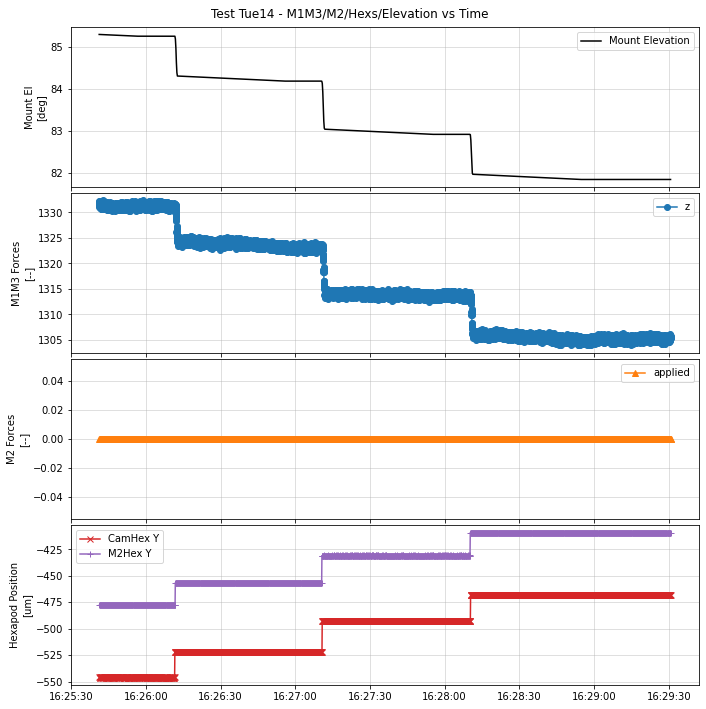

In [50]:
fig, axs = plt.subplots(figsize=(10, 10), nrows=4, sharex=True)

axs[0].plot(df["mount_el"].dropna(), "k", label="Mount Elevation")
axs[0].set_ylabel("Mount El\n[deg]")

axs[1].plot(df["m1m3_z101"].dropna(), "C0o-", label="z101")
axs[1].set_ylabel("M1M3 Forces\n[--]")

axs[2].plot(df["m2b1_applied"].dropna(), "C1^-", label="applied")
#axs[2].plot(df["m2b1_gravLut"].dropna(), "C2v-", label="Gravity LUT")
axs[2].set_ylabel("M2 Forces\n[--]")

axs[3].plot(df["camhex_y"].dropna(), "C3x-", label="CamHex Y")
axs[3].plot(df["m2hex_y"].dropna(), "C4+-", label="M2Hex Y")
axs[3].set_ylabel("Hexapod Position\n[um]")

for ax in axs:
    ax.grid(":", alpha=0.5)
    ax.legend()

fig.suptitle(f"{test_execution} - M1M3/M2/Hexs/Elevation vs Time")
fig.tight_layout(h_pad=0.3)
fig.patch.set_facecolor('white')   

fig.savefig(f"plots/{test_execution}_m1m3_m2_hexs_el_vs_time_without_aberr.png")
plt.show()

## Gather Data - With Aberrations
Do 4 slews in sequence.
For each slew,

2 seconds before the slew starts, use MTAOS to add some aberrations to the system. The aberrations should correspond to 1um of z4 (focus), z5(astigmatism), z7 (y-coma), and z9 (trefoil), respectively track for 39s, simulating a visit.

Note: the 4 slews need to correspond to elevation angle between 86.5 deg and 82 deg. And, additional margin is needed due to tracking.

In [54]:
# Create between 86.5 and 82 deg elevation. 
target_1 = mtcs.radec_from_azel(az=230.5, el=85.4)
target_2 = mtcs.radec_from_azel(az=231, el=84.5)
target_3 = mtcs.radec_from_azel(az=230.5, el=83.4)
target_4 = mtcs.radec_from_azel(az=231, el=82.5)

print(f"Target 1: {target_1}\n"
      f"Target 2: {target_2}\n"
      f"Target 3: {target_3}\n"
      f"Target 4: {target_4}\n")

Target 1: <ICRS Coordinate: (ra, dec) in deg
    (76.33106136, -33.1330528)>
Target 2: <ICRS Coordinate: (ra, dec) in deg
    (75.43786881, -33.63858342)>
Target 3: <ICRS Coordinate: (ra, dec) in deg
    (74.40768747, -34.33366273)>
Target 4: <ICRS Coordinate: (ra, dec) in deg
    (73.47800783, -34.81090727)>



In [55]:
from astropy.time import Time, TimeDelta


In [56]:
# Set this to True when you actually want to run this test
if True:
    # t_start_aberr = time.Time(utils.current_tai(), format="unix", scale="tai")
    # t_start_aberr.format = "isot"
    # print(f"Gathering data - with Aberrations - Start time: {t_start_aberr.utc}")
    
    t_start_aberr = Time(Time.now(), format='fits', scale='utc')
    
    await asyncio.sleep(2.)

    # First target   # 1 um of z4 (Focus)
    await mtcs.rem.mtaos.cmd_resetCorrection.start()
    await mtcs.rem.mtaos.cmd_issueCorrection.start(timeout=60.)

    wavefront_errors = np.zeros(19)
    wavefront_errors[0] = 1.0 
    await mtcs.rem.mtaos.cmd_addAberration.set_start(wf=wavefront_errors, timeout=10)
    await mtcs.rem.mtaos.cmd_issueCorrection.start(timeout=60.)
    
    await asyncio.sleep(2.)

    # Wait 2 s and slew to first target
    await mtcs.slew_icrs(ra=target_1.ra, dec=target_1.dec, rot_type=RotType.PhysicalSky)
    await asyncio.sleep(37.)
    
    #await mtcs.stop_tracking()

    # Second target  # 1 um of z5 (Astigmatism)
    await mtcs.rem.mtaos.cmd_resetCorrection.start()
    await mtcs.rem.mtaos.cmd_issueCorrection.start(timeout=60.)

    wavefront_errors = np.zeros(19)
    wavefront_errors[1] = 1.0 
    await mtcs.rem.mtaos.cmd_addAberration.set_start(wf=wavefront_errors, timeout=10)
    await mtcs.rem.mtaos.cmd_issueCorrection.start(timeout=60.)

    # Wait 2 s and slew to second target
    await asyncio.sleep(2.)
    await mtcs.slew_icrs(ra=target_2.ra, dec=target_2.dec, rot_type=RotType.PhysicalSky)
    await asyncio.sleep(37.)
    
    #await mtcs.stop_tracking()

    
    # Third target  # 1 um of z7 (y-coma)
    await mtcs.rem.mtaos.cmd_resetCorrection.start()
    await mtcs.rem.mtaos.cmd_issueCorrection.start(timeout=60.)

    wavefront_errors = np.zeros(19)
    wavefront_errors[3] = 1.0 
    await mtcs.rem.mtaos.cmd_addAberration.set_start(wf=wavefront_errors, timeout=10)
    await mtcs.rem.mtaos.cmd_issueCorrection.start(timeout=60.)

    # Wait 2 s and slew to third target
    await asyncio.sleep(2.)
    await mtcs.slew_icrs(ra=target_3.ra, dec=target_3.dec, rot_type=RotType.PhysicalSky)
    await asyncio.sleep(37.)
    
    #await mtcs.stop_tracking()
  
    # Fourth target  # 1 um of z9 (trefoil)
    await mtcs.rem.mtaos.cmd_resetCorrection.start()
    await mtcs.rem.mtaos.cmd_issueCorrection.start(timeout=60.)

    wavefront_errors = np.zeros(19)
    wavefront_errors[5] = 1.0 
    await mtcs.rem.mtaos.cmd_addAberration.set_start(wf=wavefront_errors, timeout=10)
    await mtcs.rem.mtaos.cmd_issueCorrection.start(timeout=60.)

    # Wait 2 s and slew to fourth target
    await asyncio.sleep(2.)
    await mtcs.slew_icrs(ra=target_4.ra, dec=target_4.dec, rot_type=RotType.PhysicalSky)
    await asyncio.sleep(39.)  
      
    # Stop tracking
    await mtcs.stop_tracking()
    await mtcs.rem.mtaos.cmd_resetCorrection.start()
    await mtcs.rem.mtaos.cmd_issueCorrection.start(timeout=60.)

    t_end_aberr = Time(Time.now(), format='fits', scale='utc')
    # t_end_aberr = time.Time(utils.current_tai(), format="unix", scale="tai")
    # t_end_aberr.format = "isot"
    print(f"Gathering data - with Aberrations - End time: {t_end_aberr}")
    

Gathering data - with Aberrations - End time: 2022-06-14T16:38:24.966


In [78]:
print(t_start_aberr, t_end_aberr)

2022-06-14T16:34:15.195 2022-06-14T16:38:24.966


## Plot Optics vs Time

Plot the following as a function of time during the above process:

- mount elevation
- m1m3 actuator 101 z force
- m2 actuator B1 force
- camera hex y position
- m2 hex y position

In [58]:
# Query telemetry
df_aberr = await get_data_from_efd(
    exec_info.loc, 
    t_start_aberr, 
    t_end_aberr)

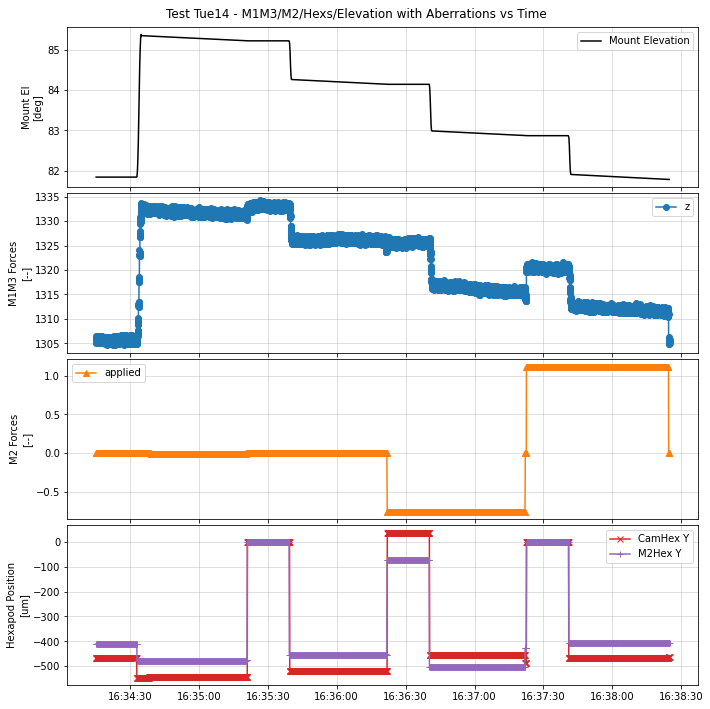

In [63]:
fig, axs = plt.subplots(figsize=(10, 10), nrows=4, sharex=True)

axs[0].plot(df_aberr["mount_el"].dropna(), "k", label="Mount Elevation")
axs[0].set_ylabel("Mount El\n[deg]")

axs[1].plot(df_aberr["m1m3_z101"].dropna(), "C0o-", label="z")
axs[1].set_ylabel("M1M3 Forces\n[--]")

axs[2].plot(df_aberr["m2b1_applied"].dropna(), "C1^-", label="applied")
#axs[2].plot(df_aberr["m2b1_gravLut"].dropna(), "C2v-", label="Gravity LUT")
axs[2].set_ylabel("M2 Forces\n[--]")

axs[3].plot(df_aberr["camhex_y"].dropna(), "C3x-", label="CamHex Y")
axs[3].plot(df_aberr["m2hex_y"].dropna(), "C4+-", label="M2Hex Y")
axs[3].set_ylabel("Hexapod Position\n[um]")

for ax in axs:
    ax.grid(":", alpha=0.5)
    ax.legend()

fig.suptitle(f"{test_execution} - M1M3/M2/Hexs/Elevation with Aberrations vs Time")
fig.tight_layout(h_pad=0.3)
fig.patch.set_facecolor('white')   

fig.savefig(f"plots/{test_execution}_m1m3_m2_hexs_el_vs_time_with_aberr.png")
plt.show()

## Compare against the corrections sent by MTAOS. 

check the force and hexapod position differences between steps 10 and 12.

Compare against the corrections sent by MTAOS. They should match.

M1M3 and M2 not using LUT so when no aberrations are applied, all forces are 0. 

In [ ]:
# t_start = "2022-06-06T00:53:47.387"
# t_start = time.Time(t_start, format="isot", scale="tai")
# start_time_aberr = t_start

# t_end = "2022-06-06T01:10:25.569"
# t_end = time.Time(t_end, format="isot", scale="tai")
# end_time_aberr = t_end

### M1 forces vs MTAOS corrections

In [ ]:
print(t_start_aberr, t_end_aberr.utc)

In [64]:
m1m3_correction = await client.select_time_series(
    'lsst.sal.MTAOS.logevent_m1m3Correction', 
    [f"zForces{i}" for i in range(156)], 
    t_start_aberr, 
    t_end_aberr
)

In [65]:
m1m3_correction_applied = await client.select_time_series(
    'lsst.sal.MTM1M3.command_applyActiveOpticForces', 
    [f"zForces{i}" for i in range(156)], 
    t_start_aberr.utc, 
    t_end_aberr.utc
)

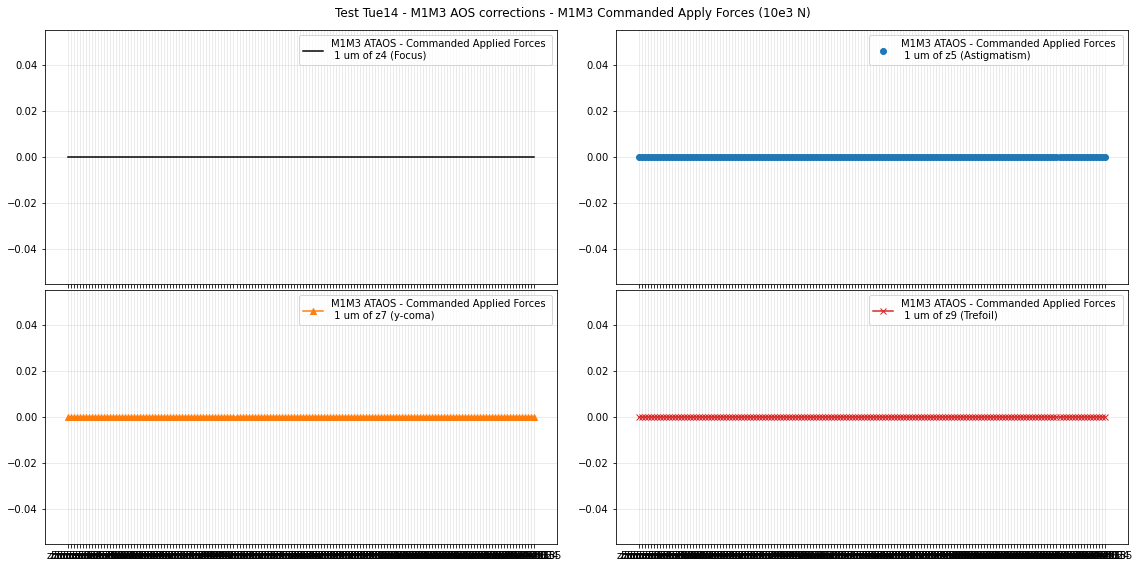

In [66]:
fig, axs = plt.subplots(2,2, figsize=(16, 8), sharex=True)

axs[0,0].plot(m1m3_correction.iloc[1].dropna()-m1m3_correction_applied.iloc[1].dropna(), "k", label="M1M3 ATAOS - Commanded Applied Forces \n 1 um of z4 (Focus)")
#axs[0,0].plot(m1m3_correction_applied.iloc[0].dropna(), "C0o", label="M1M3 Applied Focus")

axs[0,1].plot(m1m3_correction.iloc[3].dropna()-m1m3_correction_applied.iloc[3].dropna(), "C0o", label="M1M3 ATAOS - Commanded Applied Forces \n 1 um of z5 (Astigmatism)")
#axs[0,1].plot(m1m3_correction_applied.iloc[1].dropna(), "C0o", label="M1M3 Applied Focus")

axs[1,0].plot(m1m3_correction.iloc[5].dropna()-m1m3_correction_applied.iloc[5].dropna(), "C1^-", label="M1M3 ATAOS - Commanded Applied Forces \n 1 um of z7 (y-coma)")
#axs[1,0].plot(m1m3_correction_applied.iloc[2].dropna(), "C0o", label="M1M3 Applied Focus")

axs[1,1].plot(m1m3_correction.iloc[7].dropna()-m1m3_correction_applied.iloc[7].dropna(), "C3x-", label="M1M3 ATAOS - Commanded Applied Forces \n 1 um of z9 (Trefoil)")
#axs[1,1].plot(m1m3_correction_applied.iloc[3].dropna(), "C0o", label="M1M3 Applied Focus")

for ax in axs.flat:
    ax.grid(":", alpha=0.3)
    ax.legend()

fig.suptitle(f"{test_execution} - M1M3 AOS corrections - M1M3 Commanded Apply Forces (10e3 N)")
fig.tight_layout(h_pad=0.3)
fig.patch.set_facecolor('white')   

fig.savefig(f"plots/{test_execution}_m1m3_forces_vs_aos.png")
plt.show()

### M2 forces vs MTAOS corrections

In [67]:
m2_correction = await client.select_time_series(
    'lsst.sal.MTAOS.logevent_m2Correction', 
    [f"zForces{i}" for i in range(72)], 
    t_start_aberr, 
    t_end_aberr
)
# Change column names to match that of commanded forces, aka axial. 
m2_correction.columns = m2_correction.columns.str.replace("zForces", "axial")

In [68]:
m2_correction_applied = await client.select_time_series(
    'lsst.sal.MTM2.command_applyForces', 
    [f"axial{i}" for i in range(72)], 
    t_start_aberr, 
    t_end_aberr)

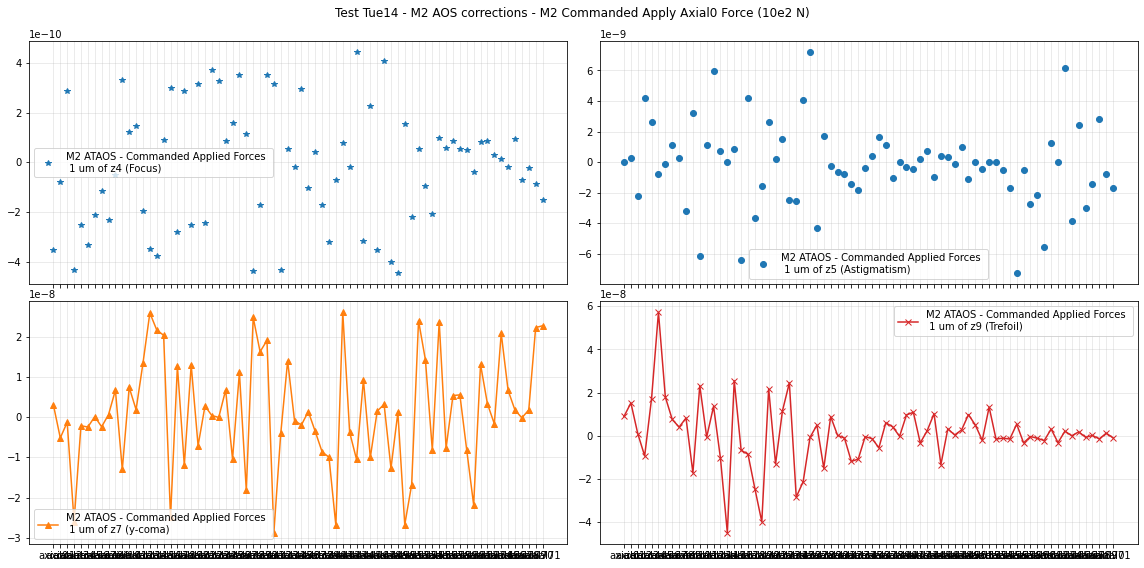

In [69]:
fig, axs = plt.subplots(2,2, figsize=(16, 8), sharex=True)

axs[0,0].plot(m2_correction.iloc[1]-m2_correction_applied.iloc[1], "C0*", label="M2 ATAOS - Commanded Applied Forces \n 1 um of z4 (Focus)")
#axs[0,0].plot(m1m3_correction_applied.iloc[0].dropna(), "C0o", label="M1M3 Applied Focus")

axs[0,1].plot(m2_correction.iloc[3]-m2_correction_applied.iloc[3], "C0o", label="M2 ATAOS - Commanded Applied Forces \n 1 um of z5 (Astigmatism)")
#axs[0,1].plot(m1m3_correction_applied.iloc[1].dropna(), "C0o", label="M1M3 Applied Focus")

axs[1,0].plot(m2_correction.iloc[5]-m2_correction_applied.iloc[5], "C1^-", label="M2 ATAOS - Commanded Applied Forces \n 1 um of z7 (y-coma)")
#axs[1,0].plot(m1m3_correction_applied.iloc[2].dropna(), "C0o", label="M1M3 Applied Focus")

axs[1,1].plot(m2_correction.iloc[7]-m2_correction_applied.iloc[7], "C3x-", label="M2 ATAOS - Commanded Applied Forces \n 1 um of z9 (Trefoil)")
#axs[1,1].plot(m1m3_correction_applied.iloc[3].dropna(), "C0o", label="M1M3 Applied Focus")

for ax in axs.flat:
    ax.grid(":", alpha=0.3)
    ax.legend()

fig.suptitle(f"{test_execution} - M2 AOS corrections - M2 Commanded Apply Axial0 Force (10e2 N)")
fig.tight_layout(h_pad=0.3)
fig.patch.set_facecolor('white')   

fig.savefig(f"plots/{test_execution}_m2_with_aberr.png")
plt.show()

### CamHex vs MTAOS corrections

In [ ]:
allaxesinPosition = 

In [71]:
from lsst_efd_client import EfdClient, rendezvous_dataframes

In [72]:
# Position difference
df_camhex1 = await client.select_time_series(
        "lsst.sal.MTHexapod.application",
        ["position1", "position2", "position3"],
        t_start_aberr, 
        t_end_aberr,
        index=2
    )

dfm_elevation1 = await client.select_time_series(
        'lsst.sal.MTMount.elevation', 'actualPosition', 
        t_start_aberr, t_end_aberr)

df_camhex1_aberr = rendezvous_dataframes(
        df_camhex1, 
        dfm_elevation1,
    )

# Change column names
df_camhex1_aberr.rename(columns={"actualPosition": "el_aberr"}, inplace=True)
df_camhex1_aberr.rename(columns={"position1": "x_aberr"}, inplace=True)
df_camhex1_aberr.rename(columns={"position2": "y_aberr"}, inplace=True)
df_camhex1_aberr.rename(columns={"position3": "z_aberr"}, inplace=True)

#df_camhex1_aberr.set_index("el_aberr")

In [73]:
# Position difference
df_camhex2 = await client.select_time_series(
        "lsst.sal.MTHexapod.application",
        ["position1", "position2", "position3"],
        t_start.utc, 
        t_end.utc,
        index=2
    )

dfm_elevation2 = await client.select_time_series(
        'lsst.sal.MTMount.elevation', 'actualPosition', 
        t_start.utc, t_end.utc)

df_camhex2 = rendezvous_dataframes(
        df_camhex2, 
        dfm_elevation2,
    )

# Change column names
df_camhex2.rename(columns={"actualPosition": "el_aberr"}, inplace=True)
df_camhex2.rename(columns={"position1": "x_without"}, inplace=True)
df_camhex2.rename(columns={"position2": "y_without"}, inplace=True)
df_camhex2.rename(columns={"position3": "z_without"}, inplace=True)

#df_camhex2.set_index("el")

In [74]:
cam_hexapod_correction_computed_xyz = await client.select_time_series(
    'lsst.sal.MTAOS.logevent_cameraHexapodCorrection', 
    ["x", "y", "z"], 
    t_start_aberr, 
    t_end_aberr
)

cam_hexapod_correction_computed_uv = await client.select_time_series(
    'lsst.sal.MTAOS.logevent_cameraHexapodCorrection', 
    ["u", "v"], 
    t_start_aberr, 
    t_end_aberr
)

In [75]:
# Rendex vous of position and elevation with AOS corrections
camhex_aberr = rendezvous_dataframes(cam_hexapod_correction_computed_xyz, df_camhex1_aberr)

In [76]:
camhex_aberr=camhex_aberr.sort_values('el_aberr').dropna()
df_camhex2 = df_camhex2.sort_values('el_aberr').dropna()
df3 = pd.merge_asof(camhex_aberr,df_camhex2, on = 'el_aberr', tolerance=.5)

In [77]:
df3

,x,y,z,x_aberr,y_aberr,z_aberr,el_aberr,x_without,y_without,z_without
0,0.000000,0.000000,0.000000,-407.817228,304.734897,-0.004799,81.786427,NaN,NaN,NaN
1,0.000136,-0.022309,-0.147910,-427.326605,305.822409,-0.005014,82.869878,-409.149374,304.866670,-0.004809
2,0.000000,0.000000,0.000000,-501.614767,305.811185,-0.001748,82.870039,-409.149374,304.866670,-0.004809
3,0.025150,37.968733,-0.008265,-453.036188,306.770886,-0.005305,84.141064,-430.871160,305.997833,-0.005053
4,0.000000,0.000000,0.000000,-455.474991,306.870724,-0.005333,84.141146,-430.871160,305.997833,-0.005053
5,0.003964,-0.001355,-0.008639,-474.921511,307.246318,-0.005551,85.217232,-456.442633,306.879538,-0.005344
6,0.000000,0.000000,0.000000,-477.329560,319.856936,-0.005578,85.217444,-456.442633,306.879538,-0.005344
7,-0.001496,-0.000997,29.065338,-477.336726,307.240014,-0.005578,85.335318,-477.894471,307.272533,-0.005585
8,0.000000,0.000000,0.000000,-477.653753,307.240822,-0.005582,85.337015,-477.894471,307.272533,-0.005585


In [ ]:
cam_hexapod_correction_applied_xyz = await client.select_time_series(
    'lsst.sal.MTHexapod.logevent_uncompensatedPosition', 
    ["x", "y", "z", "MTHexapodID"], 
    t_start_aberr, 
    t_end_aberr,
    index=1
)

cam_hexapod_correction_applied_uv = await client.select_time_series(
    'lsst.sal.MTHexapod.logevent_uncompensatedPosition', 
    ["u", "v", "MTHexapodID"], 
    t_start.utc, 
    t_end.utc,
    index=1
)

In [ ]:
cam_hexapod_correction_command_xyz = await client.select_time_series(
    'lsst.sal.MTHexapod.command_move', 
    ["x", "y", "z", "MTHexapodID"], 
    t_start_aberr, 
    t_end_aberr,
    index=1
)

cam_hexapod_correction_command_uv = await client.select_time_series(
    'lsst.sal.MTHexapod.command_move', 
    ["u", "v", "MTHexapodID"], 
    t_start_aberr, 
    t_end_aberr,
    index=1
)

In [ ]:
cam_hexapod_correction_computed_xyz, cam_hexapod_correction_applied_xyz, cam_hexapod_correction_command_xyz

### M2Hex vs MTAOS corrections

In [ ]:
m2_hexapod_correction_computed_xyz = await client.select_time_series(
    'lsst.sal.MTAOS.logevent_m2HexapodCorrection', 
    ["x", "y", "z"], 
    start.utc, 
    end.utc
)

m2_hexapod_correction_computed_uv = await client.select_time_series(
    'lsst.sal.MTAOS.logevent_m2HexapodCorrection', 
    ["u", "v"], 
    start.utc, 
    end.utc
)

In [ ]:
m2_hexapod_correction_applied_xyz = await client.select_time_series(
    'lsst.sal.MTHexapod.logevent_uncompensatedPosition', 
    ["x", "y", "z", "MTHexapodID"], 
    start.utc, 
    end.utc,
    index=2
)

m2_hexapod_correction_applied_uv = await client.select_time_series(
    'lsst.sal.MTHexapod.logevent_uncompensatedPosition', 
    ["u", "v", "MTHexapodID"], 
    start.utc, 
    end.utc,
    index=2
)

In [ ]:
m2_hexapod_correction_command_xyz = await client.select_time_series(
    'lsst.sal.MTHexapod.command_move', 
    ["x", "y", "z", "MTHexapodID"], 
    start.utc, 
    end.utc,
    index=2
)

m2_hexapod_correction_command_uv = await client.select_time_series(
    'lsst.sal.MTHexapod.command_move', 
    ["u", "v", "MTHexapodID"], 
    start.utc, 
    end.utc,
    index=2
)

## Wrap up
lower m1m3,
put hardware to OFFLINE
put all simulators to STANDBY
done.

In [79]:
# Put the telescope back to the original position
# Specially if running at TTS
await mtcs.point_azel(az=0, el=80)

In [80]:
await mtcs.lower_m1m3()

In [ ]:
await mtcs.set_state(state=salobj.State.STANDBY, components=["mtm1m3"])

In [ ]:
await mtcs.set_state(state=salobj.State.STANDBY, components=["mtaos"])

In [ ]:
await mtcs.set_state(state=salobj.State.STANDBY, components=["mtm2"])

In [ ]:
await mtcs.set_state(state=salobj.State.STANDBY, components=["mthexapod_1"])

In [ ]:
await mtcs.set_state(state=salobj.State.STANDBY, components=["mthexapod_2"])

In [ ]:
if exec_info.loc == "summit":
    await mtcs.standby()

else:
    # Bring the system back to the original state
    await mtcs.set_state(
        state=salobj.State.ENABLED,
        components=[
            "mtm1m3", 
            "mtm2",
            "mthexapod_1",
            "mthexapod_2",
            "mtaos",
        ],
        overrides={
            "mtm1m3": "Default"
        }
    )